In [1]:
# take a look at multiple representation methods

# determine which are doing worse and which are doing better

In [17]:
import numpy as np
import csv
import os
import time
import json
import mysql.connector as mysql

from sklearn.decomposition import PCA
import umap

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm  # for kdemultivariate 

In [30]:
client_config = {'unix_socket':'/home/brendanchambers/.sql.sock',
                            'database':'test_pubmed',
                            'use_pure':True}



journals = ['J. Neurophysiol.', 'Neuroimage']  # journals = ['Brain Res.', 'J. Virol.']

journal_colors = [[0, 0.25, 0.75, 0.25],
                  [0.75, 0.25, 0, 0.25]]


# table names corresponding to embedding conditions
'''
embedding_conditions = ['emb_bert_cls',
               'emb_bert_longtokens_mean',
               'emb_bert_tokens_mean',
               'emb_scibert_cls',
               'emb_scibert_longtokens_mean',
               'emb_scibert_tokens_mean']
'''
embedding_conditions = ['emb_scibert_cls',
                       'emb_scibert_longtokens_mean',
                       'emb_scibert_tokens_mean']

# todo also check representations composed from cls & tokens
#  maybe directly optimize on this

compare_embeddings = {}


In [31]:
for condition in embedding_conditions:

    compare_embeddings[condition] = {}

    db = mysql.connect(**client_config)

    for i_journal, journal in enumerate(journals):

        start_time = time.time()

        sql = '''SELECT {}.embedding
                FROM {}
                JOIN metadata ON {}.pmid=metadata.pmid
                WHERE metadata.journal = '{}' '''.format(condition, condition, condition, journal)
        print(sql)

        cursor = db.cursor()
        cursor.execute(sql)
        results = cursor.fetchall()
        print(len(results))
        cursor.close()
                
        compare_embeddings[condition][journal] = [np.frombuffer(e[0],
                                                                dtype="float64") for e in results]

        end_time = time.time()
        print("journals enumerated in {} s".format(end_time - start_time))
        print()
        
    db.close()
    
    # take a quick look    
    print(condition, journal)
    print('first few entries of the embedding vector ok?: ')
    print(compare_embeddings[condition][journal][0][:10])
    print()

SELECT emb_scibert_cls.embedding
                FROM emb_scibert_cls
                JOIN metadata ON emb_scibert_cls.pmid=metadata.pmid
                WHERE metadata.journal = 'J. Neurophysiol.' 
20115
journals enumerated in 3.828134536743164 s

SELECT emb_scibert_cls.embedding
                FROM emb_scibert_cls
                JOIN metadata ON emb_scibert_cls.pmid=metadata.pmid
                WHERE metadata.journal = 'Neuroimage' 
9886
journals enumerated in 2.7754173278808594 s

emb_scibert_cls Neuroimage
first few entries of the embedding vector ok?: 
[-0.76412809  0.15706916  0.21549053 -0.51810235  0.54233843 -0.50949758
  0.90820038 -0.36265385 -1.14964068  0.47701362]

SELECT emb_scibert_longtokens_mean.embedding
                FROM emb_scibert_longtokens_mean
                JOIN metadata ON emb_scibert_longtokens_mean.pmid=metadata.pmid
                WHERE metadata.journal = 'J. Neurophysiol.' 
20115
journals enumerated in 4.074055433273315 s

SELECT emb_scibert_longt

In [32]:
print(compare_embeddings.keys())

dict_keys(['emb_scibert_cls', 'emb_scibert_longtokens_mean', 'emb_scibert_tokens_mean'])


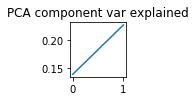

J. Neurophysiol.
20115
Neuroimage
9886


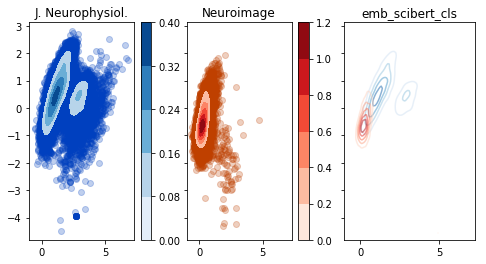

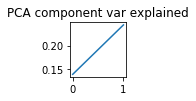

J. Neurophysiol.
20115
Neuroimage
9886


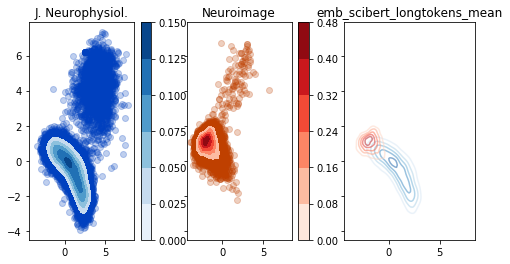

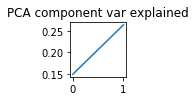

J. Neurophysiol.
20115
Neuroimage
9886


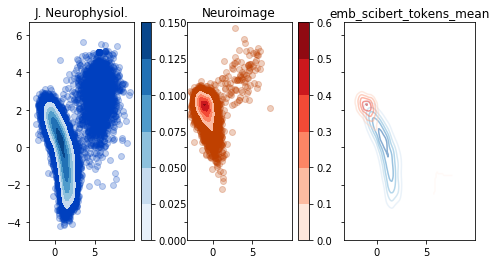

In [36]:
# todo would be nice to align these spaces and then compare

D = 768
D_pca = 2   # most of the variance preserved at around 300 d

pca_models = []

for i_cond, condition in enumerate(embedding_conditions):
    
    all_articles = np.zeros((0,D))
    
    # full list of samples across journals, to feed to pca
    for journal in journals:
        thisjournal = compare_embeddings[condition][journal].copy()
        all_articles = np.vstack( (all_articles, thisjournal))
        
    # get pca for this embedding condition
    pca = PCA(n_components=D_pca)
    pc = pca.fit_transform(all_articles)
    pca_models.append(pca)
    
    # var explained
    plt.figure(figsize=(1,1))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA component var explained')  
    plt.show()
    
    ## 2D pca comparison of journals ##
    '''
    (f, ax) = plt.subplots(1, len(journals), sharex='all', sharey='all',
                      figsize=(8,4))
    
    for i_journal, journal in enumerate(journals):
        print(journal)
        samples = compare_embeddings[embedding_conditions[i_cond]][journals[i_journal]].copy()
        print(len(samples))
        pc = pca_models[i_cond].transform(samples)
        sns.kdeplot(pc[:,0],pc[:,1],n_levels=5,
                 shade=True, # shade_lowest=False,
                 alpha=1, cmap='Blues', cbar=True,
                 ax = ax[i_journal])
        #ax[i_journal].scatter(pc[:,0], pc[:,1],
        #            color=journal_colors[i_journal],marker='.')

    plt.title('2D pca for {} '.format(condition))
    '''
    
    ## 2D pca comparison of journals ##
    (f, ax) = plt.subplots(1, len(journals)+1, sharex='all', sharey='all',
                      figsize=(8,4))

    cmap_key = ['Blues','Reds']
    for i_journal, journal in enumerate(journals):
        print(journal)
        samples = d_samples[journal]
        print(len(samples))
        pc = pca.transform(samples)
        ax[i_journal].scatter(pc[:,0], pc[:,1],color=journal_colors[i_journal])
        sns.kdeplot(pc[:,0],pc[:,1],n_levels=5,
                 shade=True, shade_lowest=False,
                 alpha=1, cmap=cmap_key[i_journal], cbar=True,
                 ax = ax[i_journal])
        ax[i_journal].set_title(journal)

        sns.kdeplot(pc[:,0],pc[:,1],n_levels=5,
                    shade=False,
                    alpha=0.5,
                    cmap=cmap_key[i_journal],
                    ax = ax[len(ax)-1])
        #ax[i_journal].scatter(pc[:,0], pc[:,1],
        #            color=journal_colors[i_journal],marker='.')

        ax[len(ax)-1].set_title(condition)



#plt.savefig('J Neurophysiol vs Neuroimaging.png')
#plt.savefig('J Neurophysiol vs Neuroimaging.svg')

In [ ]:
# try to combine CLS + tokens

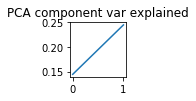

J. Neurophysiol.
20115
Neuroimage
9886


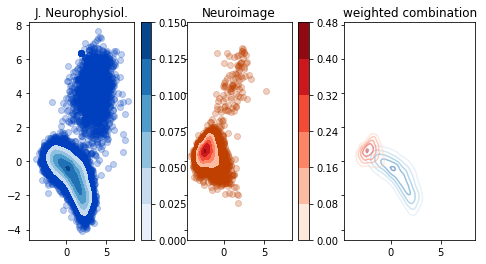

In [37]:

D = 768
D_pca = 2   # most of the variance preserved at around 300 d

pca_models = []
d_samples = {}

conditionA = 'emb_scibert_cls'
conditionB = 'emb_scibert_longtokens_mean'



all_articles = np.zeros((0,D))
# full list of samples across journals, to feed to pca
for journal in journals:
    thisjournalA = compare_embeddings[conditionA][journal]
    thisjournalB = compare_embeddings[conditionB][journal]
    thisjournal = 0.1*np.array(thisjournalA) + 0.9*np.array(thisjournalB)
    d_samples[journal] = thisjournal
    all_articles = np.vstack( (all_articles, thisjournal))    
        
# get pca for this embedding condition
pca = PCA(n_components=D_pca)
pc = pca.fit_transform(all_articles)
#pca_models.append(pca)
    
# var explained
plt.figure(figsize=(1,1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA component var explained')  
plt.show()
    
## 2D pca comparison of journals ##
(f, ax) = plt.subplots(1, len(journals)+1, sharex='all', sharey='all',
                  figsize=(8,4))
    
cmap_key = ['Blues','Reds']
for i_journal, journal in enumerate(journals):
    print(journal)
    samples = d_samples[journal]
    print(len(samples))
    pc = pca.transform(samples)
    ax[i_journal].scatter(pc[:,0], pc[:,1],color=journal_colors[i_journal])
    sns.kdeplot(pc[:,0],pc[:,1],n_levels=5,
             shade=True, shade_lowest=False,
             alpha=1, cmap=cmap_key[i_journal], cbar=True,
             ax = ax[i_journal])
    ax[i_journal].set_title(journal)
    
    sns.kdeplot(pc[:,0],pc[:,1],n_levels=5,
                shade=False,
                alpha=0.5,
                cmap=cmap_key[i_journal],
                ax = ax[len(ax)-1])
    #ax[i_journal].scatter(pc[:,0], pc[:,1],
    #            color=journal_colors[i_journal],marker='.')

    ax[len(ax)-1].set_title('weighted combination')
    